In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn
import warnings
warnings.filterwarnings("ignore")

# yahoo finance is used to fetch data
import yfinance as yf

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Creating  a linear regression model
from sklearn.linear_model import LinearRegression

from pmdarima import auto_arima

In [5]:
#Reading the data for the past 13 years.
df = yf.download('EURUSD=X','2003-01-01','2021-10-11',auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [6]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,0
2003-12-02,1.196101,1.210903,1.194600,1.208897,0
2003-12-03,1.209000,1.213003,1.207700,1.212298,0
2003-12-04,1.212004,1.214403,1.204398,1.208094,0
2003-12-05,1.207802,1.219096,1.206593,1.218695,0


In [8]:
data=df[['Close']]

In [10]:
data.isna().sum()

Close    0
dtype: int64

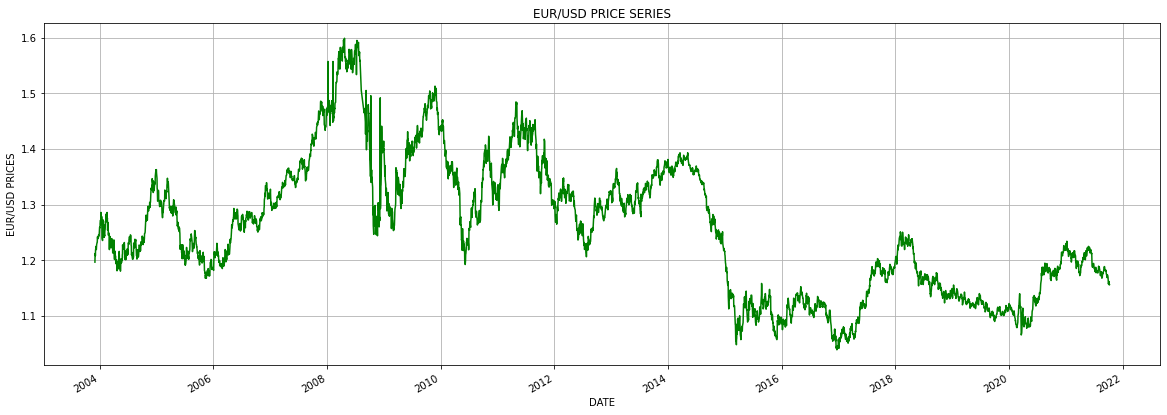

In [11]:
data['Close'].plot(figsize=(20,7),color='g',grid=True)
plt.xlabel('DATE')
plt.ylabel('EUR/USD PRICES')
plt.title('EUR/USD PRICE SERIES')
plt.show()

In [12]:
data['3_Days']=data['Close'].shift(1).rolling(window=3).mean()
data['9_Days']=data['Close'].shift(1).rolling(window=3).mean()

In [14]:
#Checking for null values
data.isna().sum()

Close     0
3_Days    3
9_Days    3
dtype: int64

In [15]:
data=data.dropna()

In [17]:
X=data[['3_Days','9_Days']]
X.head()

,3_Days,9_Days
Date,,
2003-12-04,1.205899,1.205899
2003-12-05,1.209763,1.209763
2003-12-08,1.213029,1.213029
2003-12-09,1.216263,1.216263
2003-12-10,1.221897,1.221897


In [18]:
y=data['Close']
y.head()

Date
2003-12-04    1.208094
2003-12-05    1.218695
2003-12-08    1.222001
2003-12-09    1.224995
2003-12-10    1.219096
Name: Close, dtype: float64

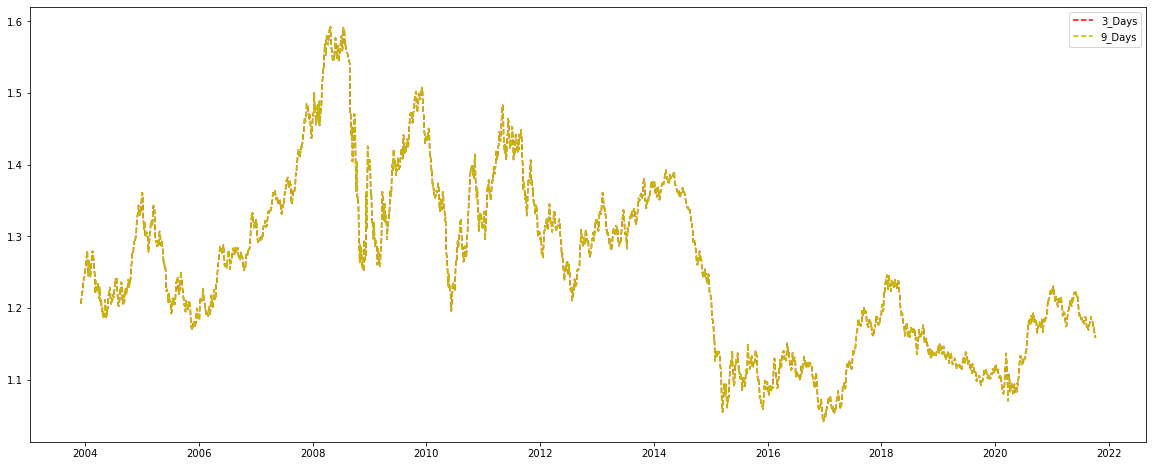

In [19]:

plt.figure(figsize=(20,8))
plt.plot(data['3_Days'],ls='--',color='r',) 
plt.plot( data["9_Days"] , ls='--',color ='y')
plt.legend(['3_Days', '9_Days'])

In [20]:
#Splitting  the data into train and test dataset

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, shuffle=False)

In [32]:
print('X train: '+str(X_train.shape))
print('y train: '+str(y_train.shape))
print('X test: '+str(X_test.shape))
print('y test: '+str(y_test.shape))

X train: (3702, 2)
y train: (3702,)
X test: (926, 2)
y test: (926,)


In [34]:
linear = LinearRegression().fit(X_train, y_train)


print("---------Linear Regression model------------")

print("EURUSD  Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 9 Days Moving Average (x2) \
+ %.2f (c)" % (linear.coef_[0], linear.coef_[1], linear.intercept_))

---------Linear Regression model------------
EURUSD  Price (y) = 0.50 * 3 Days Moving Average (x1) + 0.50 * 9 Days Moving Average (x2) + 0.00 (c)


In [35]:
# Predicting the EURUSD  prices based on the test dataset 

pre_price = linear.predict(X_test)
pre_price = pd.DataFrame(pre_price, index=y_test.index, columns=['price'])

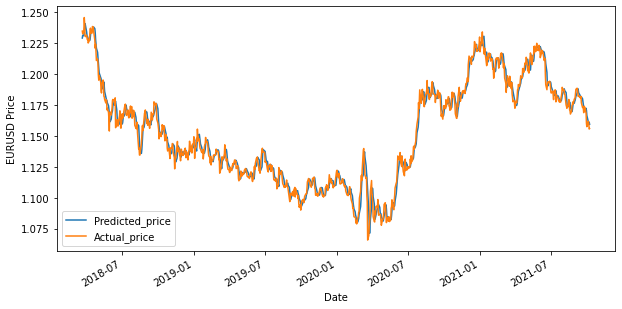

In [36]:
#Visualizing the predicted dataset with the test dataset 

pre_price.plot(figsize=(10, 5),)
y_test.plot()

plt.legend(['Predicted_price', 'Actual_price'])
plt.ylabel("EURUSD Price")
plt.show()

In [37]:
# Model Evaluation 
#Calculating the r square and mse.

r2_score = linear.score(X_test, y_test)*100

print("R square for regression is ", float("{0:.2f}".format(r2_score)))
np.sqrt(mean_squared_error(y_test,pre_price))

R square for regression is  97.94


0.005833557332348347

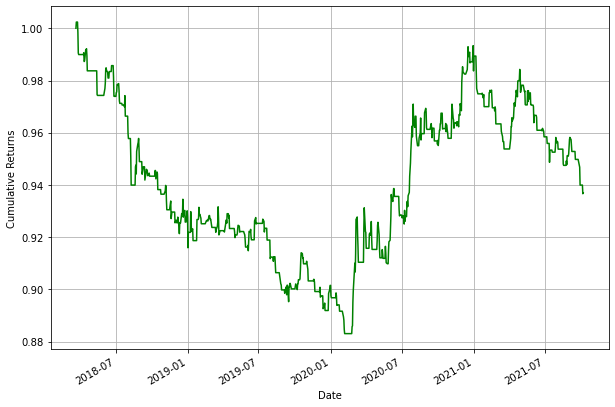

In [38]:
#Plotting the Cummalitve returns to analyse its performance

#comparing predicted price of today with next day for further direction.
eur_usd = pd.DataFrame()
t=int(0.8*len(data)) 
eur_usd['price'] = data[t:]['Close']
eur_usd['predicted_price_next_day'] = pre_price
eur_usd['actual_price_next_day'] = y_test
eur_usd['gold_returns'] = eur_usd['price'].pct_change().shift(-1)


eur_usd['signal'] = np.where(eur_usd.predicted_price_next_day.shift(1) < eur_usd.predicted_price_next_day,1,0)
eur_usd['strategy_returns'] = eur_usd.signal * eur_usd['gold_returns']
((eur_usd['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g',grid=True)
plt.ylabel('Cumulative Returns')
plt.show()

In [39]:
#to predict the EURUSD prices and give a position
# whether one should buy EURUSD or take no position.
#Reading the data for the past 13 years.
test_eur_usd = yf.download('EURUSD=X','2003-01-01','2021-10-11',auto_adjust=True)
test_eur_usd['3_Day'] = test_eur_usd['Close'].rolling(window=3).mean()
test_eur_usd['9_Day'] = test_eur_usd['Close'].rolling(window=9).mean()
test_eur_usd = test_eur_usd.dropna()

test_eur_usd['predicted_gold_price'] = linear.predict(test_eur_usd[['3_Day', '9_Day']])
test_eur_usd['Position'] = np.where(test_eur_usd.predicted_gold_price.shift(1) < test_eur_usd.predicted_gold_price,"Buy","No Position")
test_eur_usd.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,3_Day,9_Day,predicted_gold_price,Position
Date,,,,,,,,,
2003-12-11,1.219096,1.223496,1.212298,1.222404,0,1.222165,1.214776,1.218680,No Position
2003-12-12,1.222703,1.230603,1.221300,1.227898,0,1.223133,1.218264,1.220902,Buy
2003-12-15,1.218695,1.232499,1.217804,1.231997,0,1.227433,1.220831,1.224325,Buy
2003-12-16,1.231406,1.235895,1.230497,1.232195,0,1.230697,1.223042,1.227053,Buy
2003-12-17,1.231997,1.242005,1.229997,1.240202,0,1.234798,1.226609,1.230876,Buy
2003-12-18,1.240202,1.244199,1.236598,1.242298,0,1.238232,1.229232,1.233895,Buy
2003-12-19,1.242205,1.243503,1.235102,1.238497,0,1.240333,1.231065,1.235855,Buy
2003-12-22,1.235697,1.244601,1.235697,1.239895,0,1.240230,1.232720,1.236630,Buy
2003-12-23,1.239895,1.267202,1.238804,1.240003,0,1.239465,1.235043,1.237406,Buy


In [41]:
test_eur_usd.tail(100)

,Open,High,Low,Close,Volume,3_Day,9_Day,predicted_gold_price,Position
Date,,,,,,,,,
2021-05-24,1.218116,1.222942,1.217582,1.218324,0,1.219383,1.215700,1.217754,No Position
2021-05-25,1.221449,1.226700,1.221240,1.221464,0,1.220775,1.216480,1.218837,Buy
2021-05-26,1.224890,1.226500,1.220003,1.224909,0,1.221565,1.218375,1.220176,Buy
2021-05-27,1.219036,1.221699,1.217567,1.219260,0,1.221877,1.219656,1.220970,Buy
2021-05-28,1.219274,1.220107,1.213342,1.219319,0,1.221163,1.220132,1.220851,No Position
...,...,...,...,...,...,...,...,...,...
2021-10-04,1.160726,1.164009,1.158856,1.160726,0,1.159444,1.167116,1.163661,No Position
2021-10-05,1.161656,1.162250,1.158306,1.161845,0,1.160006,1.165955,1.163362,No Position
2021-10-06,1.159514,1.159958,1.153017,1.159608,0,1.160726,1.164937,1.163214,No Position


In [42]:
model=auto_arima(y=y_train,exogenous=X_train,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-23270.994, Time=4.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-22615.924, Time=0.52 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-23194.891, Time=1.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-23147.869, Time=2.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-22614.161, Time=1.28 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-23267.278, Time=3.74 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-23200.115, Time=3.80 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-23263.429, Time=5.41 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-23220.185, Time=5.91 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-23205.147, Time=1.87 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-23269.808, Time=3.52 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-23249.454, Time=4.93 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-23260.903, Time=5.72 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-23268.358, Time=2.13 sec

Best

In [43]:
arima_pre=model.predict(n_periods=len(X_test),exogenous=X_test)

C:\Users\luka.radovanovic\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [44]:
arima_pred_price = pd.DataFrame(arima_pre, index=y_test.index, columns=['price'])

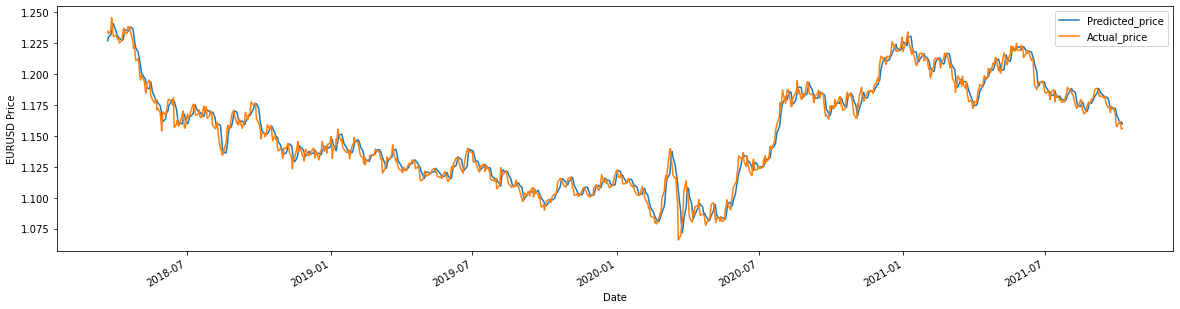

In [46]:
#Visualizing the predicted dataset with the test dataset 

arima_pred_price.plot(figsize=(20, 5),)
y_test.plot()

plt.legend(['Predicted_price', 'Actual_price'])
plt.ylabel("EURUSD Price")
plt.show()

In [47]:
# Model Evaluation 
#Calculating the r square and mse.

r2_score = linear.score(X_test, y_test)*100

print("R square for regression is ", float("{0:.2f}".format(r2_score)))
np.sqrt(mean_squared_error(y_test,arima_pred_price))

R square for regression is  97.94


0.005852792647750227

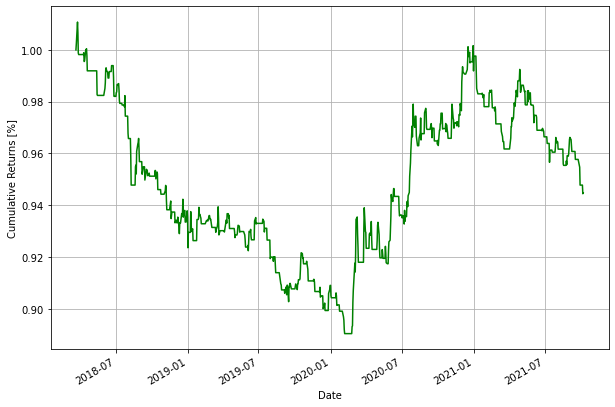

In [48]:
eurusd_arima = pd.DataFrame()
t=int(0.8*len(data)) 
eurusd_arima['price'] = data[t:]['Close']
eurusd_arima['predicted_price_next_day'] = arima_pred_price
eurusd_arima['actual_price_next_day'] = y_test
eurusd_arima['gold_returns'] = eurusd_arima['price'].pct_change().shift(-1)


eurusd_arima['signal'] = np.where(eurusd_arima.predicted_price_next_day.shift(1) < eurusd_arima.predicted_price_next_day,1,0)
eurusd_arima['strategy_returns'] = eurusd_arima.signal * eurusd_arima['gold_returns']
((eurusd_arima['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g',grid=True)
plt.ylabel('Cumulative Returns [%]')
plt.show()

In [49]:
#to predict the EURUSD prices and give a position
# whether one should buy EURUSD or take no position.
#Reading the data for the past 13 years.
test_eur_usd_arima = yf.download('EURUSD=X','2003-01-01','2021-10-11',auto_adjust=True)
test_eur_usd_arima['3_Day'] = test_eur_usd_arima['Close'].rolling(window=3).mean()
test_eur_usd_arima['9_Day'] = test_eur_usd_arima['Close'].rolling(window=9).mean()
test_eur_usd_arima = test_eur_usd_arima.dropna()

test_eur_usd_arima['predicted_gold_price'] = linear.predict(test_eur_usd_arima[['3_Day', '9_Day']])
test_eur_usd_arima['Position'] = np.where(test_eur_usd_arima.predicted_gold_price.shift(1) < test_eur_usd_arima.predicted_gold_price,"Buy","No Position")
test_eur_usd_arima.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,3_Day,9_Day,predicted_gold_price,Position
Date,,,,,,,,,
2003-12-11,1.219096,1.223496,1.212298,1.222404,0,1.222165,1.214776,1.218680,No Position
2003-12-12,1.222703,1.230603,1.221300,1.227898,0,1.223133,1.218264,1.220902,Buy
2003-12-15,1.218695,1.232499,1.217804,1.231997,0,1.227433,1.220831,1.224325,Buy
2003-12-16,1.231406,1.235895,1.230497,1.232195,0,1.230697,1.223042,1.227053,Buy
2003-12-17,1.231997,1.242005,1.229997,1.240202,0,1.234798,1.226609,1.230876,Buy
2003-12-18,1.240202,1.244199,1.236598,1.242298,0,1.238232,1.229232,1.233895,Buy
2003-12-19,1.242205,1.243503,1.235102,1.238497,0,1.240333,1.231065,1.235855,Buy
2003-12-22,1.235697,1.244601,1.235697,1.239895,0,1.240230,1.232720,1.236630,Buy
2003-12-23,1.239895,1.267202,1.238804,1.240003,0,1.239465,1.235043,1.237406,Buy


In [50]:
test_eur_usd_arima.tail(10)

,Open,High,Low,Close,Volume,3_Day,9_Day,predicted_gold_price,Position
Date,,,,,,,,,
2021-09-27,1.172209,1.172800,1.168661,1.172305,0,1.171701,1.174739,1.173570,No Position
2021-09-28,1.169604,1.170600,1.166997,1.169680,0,1.172004,1.173537,1.173122,No Position
2021-09-29,1.168688,1.169200,1.161009,1.168634,0,1.170206,1.172052,1.171486,No Position
2021-09-30,1.160227,1.161170,1.157006,1.160160,0,1.166158,1.170209,1.168549,No Position
2021-10-01,1.157421,1.160900,1.156390,1.157448,0,1.162081,1.168482,1.165656,No Position
2021-10-04,1.160726,1.164009,1.158856,1.160726,0,1.159444,1.167116,1.163661,No Position
2021-10-05,1.161656,1.162250,1.158306,1.161845,0,1.160006,1.165955,1.163362,No Position
2021-10-06,1.159514,1.159958,1.153017,1.159608,0,1.160726,1.164937,1.163214,No Position
2021-10-07,1.155535,1.157140,1.154935,1.155535,0,1.158996,1.162882,1.161327,No Position
